# Machine Learning Technologies Assignment

### Import Libraries

In [79]:
import numpy as np
import nltk
import string
import re
from datetime import datetime


import matplotlib.pyplot as plt

import pandas as pd
pd.set_option('display.max_colwidth', 100)

import spacy
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
# from googletrans import Translator
from google_trans_new import google_translator

import gensim
from nltk.stem import WordNetLemmatizer

##Model Library

### Variable Initialization

In [5]:
punctuation = '!”$%&\‘’()*+,-./:;<=>?[\\]^_`{|}~•@'
garbage_char = 'ï¿½ðŸ˜Ù¾¹½²³Ø§Ÿ—î‰Œ±Šâš¬¤‡€º¦™œ«'

### Functions

In [6]:
def remove_links(tweet):
    """Takes a string and removes web links from it"""
    tweet = re.sub(r'http\S+', '', tweet)   # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet)  # remove bitly links
    tweet = re.sub(r'[a-zA-Z]+:\s+\\/\\/[a-zA-Z]+\.[a-zA-Z]+\\/[a-zA-Z0-9]+','',tweet) # remove http: \/\/t.co\/5JBtF54cmg
    tweet = tweet.strip('[link]')   # remove [links]
    tweet = re.sub(r'pic.twitter\S+','', tweet)
    return tweet

def remove_users(tweet):
    """Takes a string and removes retweet and @user information"""
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove re-tweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove tweeted at
    return tweet

def remove_hashtags(tweet):
    """Takes a string and removes any hash tags"""
    tweet = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove hash tags
    return tweet

def remove_av(tweet):
    """Takes a string and removes AUDIO/VIDEO tags or labels"""
    tweet = re.sub('VIDEO:', '', tweet)  # remove 'VIDEO:' from start of tweet
    tweet = re.sub('AUDIO:', '', tweet)  # remove 'AUDIO:' from start of tweet
    return tweet

def tokenize(tweet):
    """Returns tokenized representation of words in lemma form excluding stopwords"""
    result = []
    for token in gensim.utils.simple_preprocess(tweet):
        if token not in gensim.parsing.preprocessing.STOPWORDS \
                and len(token) > 2:  # drops words with less than 3 characters
            result.append(lemmatize(token))
    return result

def lemmatize(token):
    """Returns lemmatization of a token"""
    return WordNetLemmatizer().lemmatize(token, pos='v')


### Load Data

In [18]:
f = open('Dataset/mediaeval-2015-trainingset.txt', encoding = "UTF-8").read().split('\n')
cols = f[0].split('\t')
f_data = []
for tweet in f:
    t = tweet.split('\t')
    f_data.append(t)
raw_df = pd.DataFrame(f_data, columns=cols)
raw_df = raw_df.iloc[1:]
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14483 entries, 1 to 14483
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetId     14483 non-null  object
 1   tweetText   14483 non-null  object
 2   userId      14483 non-null  object
 3   imageId(s)  14483 non-null  object
 4   username    14483 non-null  object
 5   timestamp   14483 non-null  object
 6   label       14483 non-null  object
dtypes: object(7)
memory usage: 792.2+ KB


In [21]:
raw_df.head()

,tweetId,tweetText,userId,imageId(s),username,timestamp,label
1,263046056240115712,¿Se acuerdan de la película: “El día después de mañana”? Me recuerda a lo que está pasando con e...,21226711,sandyA_fake_46,iAnnieM,Mon Oct 29 22:34:01 +0000 2012,fake
2,262995061304852481,"@milenagimon: Miren a Sandy en NY! Tremenda imagen del huracán. Parece el ""Día de la Independen...",192378571,sandyA_fake_09,CarlosVerareal,Mon Oct 29 19:11:23 +0000 2012,fake
3,262979898002534400,"Buena la foto del Huracán Sandy, me recuerda a la película Día de la Independencia #ID4 #Sandy ...",132303095,sandyA_fake_09,LucasPalape,Mon Oct 29 18:11:08 +0000 2012,fake
4,262996108400271360,Scary shit #hurricane #NY http://t.co/e4JLBUfH,241995902,sandyA_fake_29,Haaaaarryyy,Mon Oct 29 19:15:33 +0000 2012,fake
5,263018881839411200,My fave place in the world #nyc #hurricane #sandy #statueofliberty 🗽 http://t.co/Ex61doZk,250315890,sandyA_fake_15,princess__natt,Mon Oct 29 20:46:02 +0000 2012,fake


### Extract features from timestamp

In [20]:
# remove typo from timestamp
df = raw_df.copy()
df['timestamp'] = df['timestamp'].apply(lambda x: re.sub(': ',':',x))
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [23]:
df["DayOfMonth"] = df["timestamp"].dt.day
df["DayOfYear"] = df["timestamp"].dt.dayofyear
df["Month"] = df["timestamp"].dt.month
df['Quarter'] = df['timestamp'].dt.quarter
df['WeekOfYear'] = df['timestamp'].dt.weekofyear
df["Year"] = df["timestamp"].dt.year
df = df.drop(["timestamp"],axis=1)

C:\ProgramData\Anaconda3\envs\mlt\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14483 entries, 1 to 14483
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetId     14483 non-null  object
 1   tweetText   14483 non-null  object
 2   userId      14483 non-null  object
 3   imageId(s)  14483 non-null  object
 4   username    14483 non-null  object
 5   label       14483 non-null  object
 6   DayOfMonth  14483 non-null  int64 
 7   DayOfYear   14483 non-null  int64 
 8   Month       14483 non-null  int64 
 9   Quarter     14483 non-null  int64 
 10  WeekOfYear  14483 non-null  int64 
 11  Year        14483 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 1.3+ MB


In [25]:
df.head()

,tweetId,tweetText,userId,imageId(s),username,label,DayOfMonth,DayOfYear,Month,Quarter,WeekOfYear,Year
1,263046056240115712,¿Se acuerdan de la película: “El día después de mañana”? Me recuerda a lo que está pasando con e...,21226711,sandyA_fake_46,iAnnieM,fake,29,303,10,4,44,2012
2,262995061304852481,"@milenagimon: Miren a Sandy en NY! Tremenda imagen del huracán. Parece el ""Día de la Independen...",192378571,sandyA_fake_09,CarlosVerareal,fake,29,303,10,4,44,2012
3,262979898002534400,"Buena la foto del Huracán Sandy, me recuerda a la película Día de la Independencia #ID4 #Sandy ...",132303095,sandyA_fake_09,LucasPalape,fake,29,303,10,4,44,2012
4,262996108400271360,Scary shit #hurricane #NY http://t.co/e4JLBUfH,241995902,sandyA_fake_29,Haaaaarryyy,fake,29,303,10,4,44,2012
5,263018881839411200,My fave place in the world #nyc #hurricane #sandy #statueofliberty 🗽 http://t.co/Ex61doZk,250315890,sandyA_fake_15,princess__natt,fake,29,303,10,4,44,2012


### Translate tweet Text 

In [26]:
#remove hyperlink
df['tweetText'] = df['tweetText'].apply(lambda x: re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '',x))

In [66]:
translator = google_translator()
df['tweetText'][14000:] = df['tweetText'][14000:].apply(lambda x: translator.translate(str(x),lang_tgt='en') )

C:\ProgramData\Anaconda3\envs\mlt\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [67]:
df.head()

,tweetId,tweetText,userId,imageId(s),username,label,DayOfMonth,DayOfYear,Month,Quarter,WeekOfYear,Year
1,263046056240115712,"Do you remember the movie: ""The day after tomorrow""? It reminds me of what is happening with Hur...",21226711,sandyA_fake_46,iAnnieM,fake,29,303,10,4,44,2012
2,262995061304852481,"@Milenagimon: Look at Sandy in NY! Tremendous image of the hurricane. It seems the ""Day of Indep...",192378571,sandyA_fake_09,CarlosVerareal,fake,29,303,10,4,44,2012
3,262979898002534400,"Good Hurricane Sandy's photo, reminds me of the independence day movie # id4 #sandy",132303095,sandyA_fake_09,LucasPalape,fake,29,303,10,4,44,2012
4,262996108400271360,Scary Shit #Hurricane #No,241995902,sandyA_fake_29,Haaaaarryyy,fake,29,303,10,4,44,2012
5,263018881839411200,My fave place in the world #nyc #hurricane #sandy #statueofliberty 🗽,250315890,sandyA_fake_15,princess__natt,fake,29,303,10,4,44,2012


In [69]:
df.to_csv('Translated_Training.csv')

### Read and Clean Translated Text(No need to translate text)

In [23]:
tr_df = pd.read_csv('Translated_Training.csv').drop(['Unnamed: 0','userId','imageId(s)','username'], axis='columns')

In [24]:
tr_df[tr_df.duplicated(['tweetText'], keep=False)]

,tweetId,tweetText,label,DayOfMonth,DayOfYear,Month,Quarter,WeekOfYear,Year
9,262977091983785985,#nyc #hurricane,fake,29,303,10,4,44,2012
23,262976546527145984,We forget tomb unknown soldier is guard 24/7365 ! Taken today #hurricane #sandy #frankenstorm,fake,29,303,10,4,44,2012
36,263060279586336768,#hurricane,fake,29,303,10,4,44,2012
59,263170243260723200,#hurricane,fake,30,304,10,4,44,2012
60,262964239646457856,#Hurricane #Sandy #NYC 🌀☔🗽,fake,29,303,10,4,44,2012
...,...,...,...,...,...,...,...,...,...
14426,443069067323539456,"""@bobubastic_:"" MH370 was found in Melaka. ""Pale buto",humor,10,69,3,1,11,2014
14427,443406856782753793,"""@bobubastic_:"" MH370 was found in Melaka. ""Pale buto",humor,11,70,3,1,11,2014
14444,445847183791632384,wow not funny at all RT xxJusticeManxx: MH370 has been found. They are all safe :),humor,18,77,3,1,12,2014
14448,445858465395654656,wow not funny at all RT xxJusticeManxx: MH370 has been found. They are all safe :),humor,18,77,3,1,12,2014


In [25]:
tr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14483 entries, 0 to 14482
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetId     14483 non-null  int64 
 1   tweetText   14482 non-null  object
 2   label       14483 non-null  object
 3   DayOfMonth  14483 non-null  int64 
 4   DayOfYear   14483 non-null  int64 
 5   Month       14483 non-null  int64 
 6   Quarter     14483 non-null  int64 
 7   WeekOfYear  14483 non-null  int64 
 8   Year        14483 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 1018.5+ KB


In [26]:
#drop duplicates from tweet text and rows with empty cells
tr_df = tr_df.drop_duplicates(subset='tweetText')
tr_df.replace(0, np.nan, inplace=True)
tr_df.dropna(axis=0,how='any',inplace=True)
tr_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11879 entries, 0 to 14482
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetId     11879 non-null  int64 
 1   tweetText   11879 non-null  object
 2   label       11879 non-null  object
 3   DayOfMonth  11879 non-null  int64 
 4   DayOfYear   11879 non-null  int64 
 5   Month       11879 non-null  int64 
 6   Quarter     11879 non-null  int64 
 7   WeekOfYear  11879 non-null  int64 
 8   Year        11879 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 928.0+ KB


In [27]:
#Apply Pre-processing to the tweetText and Tokenize
def preprocess_tweet(tweet):
    """Main master function to clean tweets, stripping noisy characters, and tokenizing use lemmatization"""
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = remove_hashtags(tweet)
    tweet = remove_av(tweet)
    tweet = tweet.lower()  # lower case
    tweet = re.sub('[' + punctuation + ']+', ' ', tweet)  # strip punctuation
    tweet = re.sub('[' + garbage_char + ']+', ' ', tweet)  # strip garbage char
    tweet = re.sub('\s+', ' ', tweet)  # remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet)  # remove numbers
    tweet_token_list = tokenize(tweet)  # apply lemmatization and tokenization
    tweet = ' '.join(tweet_token_list)
    return tweet

tr_df['tweetTextTokens'] = tr_df.tweetText.apply(preprocess_tweet)

In [28]:
tr_df.head()

,tweetId,tweetText,label,DayOfMonth,DayOfYear,Month,Quarter,WeekOfYear,Year,tweetTextTokens
0,263046056240115712,"Do you remember the movie: ""The day after tomorrow""? It reminds me of what is happening with Hur...",fake,29,303,10,4,44,2012,remember movie day tomorrow remind happen hurricane
1,262995061304852481,"@Milenagimon: Look at Sandy in NY! Tremendous image of the hurricane. It seems the ""Day of Indep...",fake,29,303,10,4,44,2012,look sandy tremendous image hurricane day independence real
2,262979898002534400,"Good Hurricane Sandy's photo, reminds me of the independence day movie # id4 #sandy",fake,29,303,10,4,44,2012,good hurricane sandy photo remind independence day movie
3,262996108400271360,Scary Shit #Hurricane #No,fake,29,303,10,4,44,2012,scary shit
4,263018881839411200,My fave place in the world #nyc #hurricane #sandy #statueofliberty 🗽,fake,29,303,10,4,44,2012,fave place world


In [45]:
df['tweetId'] = df['tweetId'].astype('int64')
# df = df.drop_duplicates(subset='tweetText')
temp = pd.merge(left=df[['tweetId','timestamp']], right=tr_df,how='right', on='tweetId',validate='1:1')
temp.head()

C:\ProgramData\Anaconda3\envs\mlt\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,tweetId,timestamp,tweetText,label,DayOfMonth,DayOfYear,Month,Quarter,WeekOfYear,Year,tweetTextTokens
0,263046056240115712,2012-10-29 22:34:01+00:00,"Do you remember the movie: ""The day after tomorrow""? It reminds me of what is happening with Hur...",fake,29,303,10,4,44,2012,remember movie day tomorrow remind happen hurricane
1,262995061304852481,2012-10-29 19:11:23+00:00,"@Milenagimon: Look at Sandy in NY! Tremendous image of the hurricane. It seems the ""Day of Indep...",fake,29,303,10,4,44,2012,look sandy tremendous image hurricane day independence real
2,262979898002534400,2012-10-29 18:11:08+00:00,"Good Hurricane Sandy's photo, reminds me of the independence day movie # id4 #sandy",fake,29,303,10,4,44,2012,good hurricane sandy photo remind independence day movie
3,262996108400271360,2012-10-29 19:15:33+00:00,Scary Shit #Hurricane #No,fake,29,303,10,4,44,2012,scary shit
4,263018881839411200,2012-10-29 20:46:02+00:00,My fave place in the world #nyc #hurricane #sandy #statueofliberty 🗽,fake,29,303,10,4,44,2012,fave place world


In [63]:
#Add date and time from timestamp
temp['Date'] = temp['timestamp'].dt.date
temp['Time'] = temp['timestamp'].dt.time
temp['ntweetTextTokens'] = temp['tweetTextTokens'].str.split().str.len()
temp.to_csv('Finalized_Training.csv')
temp.head()

,tweetId,timestamp,tweetText,label,DayOfMonth,DayOfYear,Month,Quarter,WeekOfYear,Year,tweetTextTokens,date,Date,Time,ntweetTextTokens
0,263046056240115712,2012-10-29 22:34:01+00:00,"Do you remember the movie: ""The day after tomorrow""? It reminds me of what is happening with Hur...",fake,29,303,10,4,44,2012,remember movie day tomorrow remind happen hurricane,2012-10-29,2012-10-29,22:34:01,7
1,262995061304852481,2012-10-29 19:11:23+00:00,"@Milenagimon: Look at Sandy in NY! Tremendous image of the hurricane. It seems the ""Day of Indep...",fake,29,303,10,4,44,2012,look sandy tremendous image hurricane day independence real,2012-10-29,2012-10-29,19:11:23,8
2,262979898002534400,2012-10-29 18:11:08+00:00,"Good Hurricane Sandy's photo, reminds me of the independence day movie # id4 #sandy",fake,29,303,10,4,44,2012,good hurricane sandy photo remind independence day movie,2012-10-29,2012-10-29,18:11:08,8
3,262996108400271360,2012-10-29 19:15:33+00:00,Scary Shit #Hurricane #No,fake,29,303,10,4,44,2012,scary shit,2012-10-29,2012-10-29,19:15:33,2
4,263018881839411200,2012-10-29 20:46:02+00:00,My fave place in the world #nyc #hurricane #sandy #statueofliberty 🗽,fake,29,303,10,4,44,2012,fave place world,2012-10-29,2012-10-29,20:46:02,3


### Exploratory Data Analysis

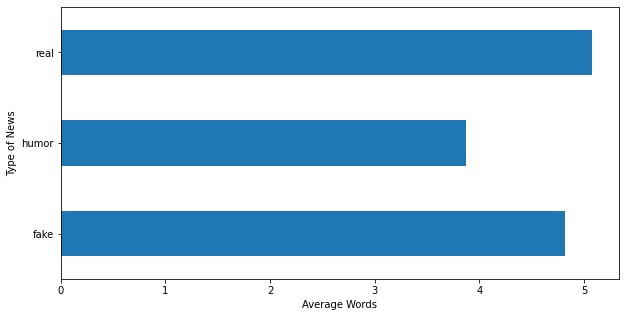

In [64]:
# Average Words in tweet text tokens vs Label
tr_df = pd.read_csv('Finalized_Training.csv')
tr_df.groupby('label')['ntweetTextTokens'].mean().plot(kind='barh',figsize=(10,5))
plt.xlabel('Average Words')
plt.ylabel('Type of News')
plt.show()

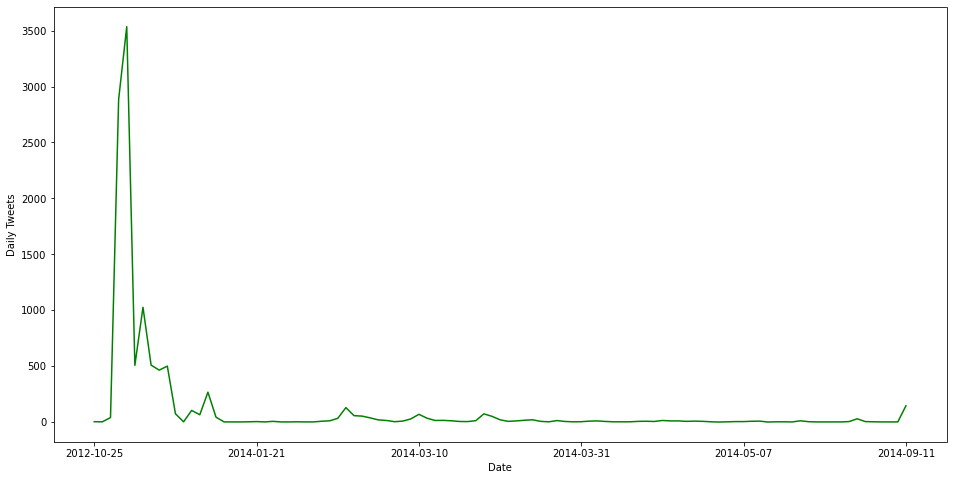

In [57]:
# Nuumber of tweets vs Date
tr_df.groupby('Date')['tweetTextTokens'].count().plot(kind='line', color='green', figsize=(16,8))
plt.xlabel('Date')
plt.ylabel('Daily Tweets')
plt.show()

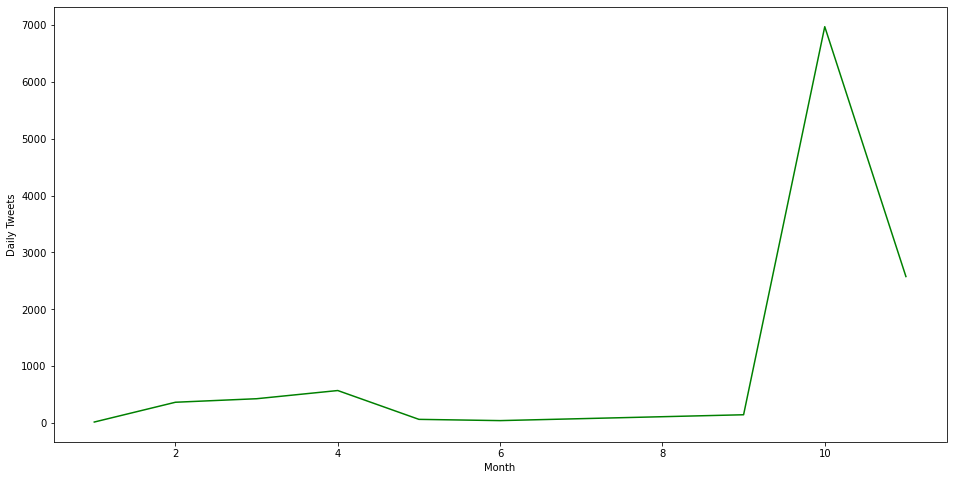

In [58]:
# Number of tweets vs Month
tr_df.groupby('Month')['tweetTextTokens'].count().plot(kind='line', color='green', figsize=(16,8))
plt.xlabel('Month')
plt.ylabel('Daily Tweets')
plt.show()

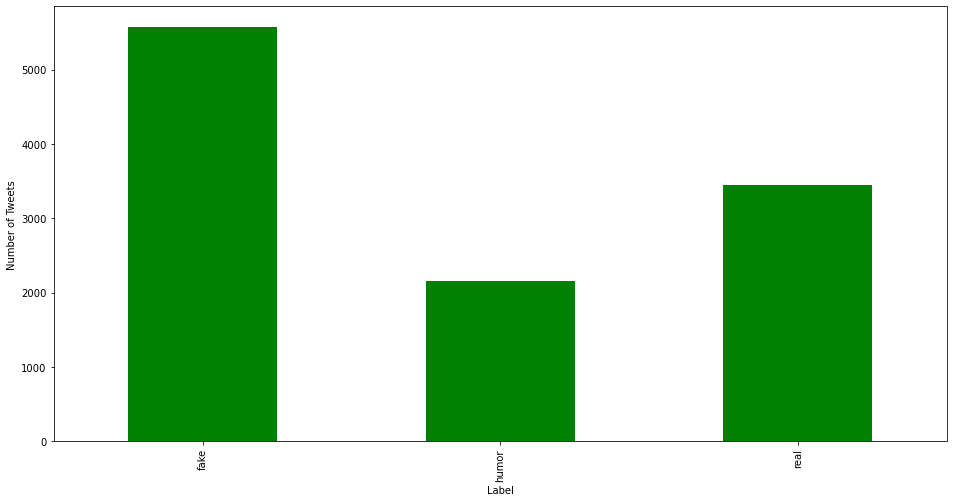

In [69]:
# Number of tweet in each label
tr_df.groupby('label')['tweetTextTokens'].count().plot(kind='bar', color='green', figsize=(16,8))
plt.xlabel('Label')
plt.ylabel('Number of Tweets')
plt.show()

In [85]:
# Number of tweet in each quarter
